### Лабораторная работа 2. Построение байесовского классификатора по прецедентам

#### $\S$ 1. Краткая теория

Пусть заданы априорные вероятности появления классов $P(\Omega_1)$, $P(\Omega_2)$ и найдены оценки плотностей распределения признаков в классах $\hat{p}(\mathrm{x}|\Omega_1)$, $\hat{p}(\mathrm{x}|\Omega_2)$. Тогда

$$
\mathrm{x}\in\Omega_1 \Leftrightarrow ~\hat{p}(\mathrm{x}|\Omega_1)P(\Omega_1) > \hat{p}(\mathrm{x}|\Omega_2)P(\Omega_2).
$$

Для оценки плотности $\hat{p}(\mathrm{x}|\Omega_i)$ используем ядерный метод. Пусть $\{\mathrm{X}_i\}_{i=1}^N$ выборка вектор-признаков объектов из класса $\Omega_i$, при этом $X_i\in\mathbf{R}^n$.

$$
\hat{p}(\mathrm{x}|\Omega_i) = \frac{1}{N\cdot h} \sum\limits_{i=1}^N K\left(\frac{\mathrm{x-X_i}}{h}\right),
$$

где функция $K$ (называемая ядром) удовлетворяет условию $\int\limits_{\mathbf{R}^n} K(\mathrm{x})d\mathrm{x} = 1 $, а параметр сглаживания h известен как полоса пропускания (bandwidth). Пример, часто используемой функции $K$ -- Гауссова функция:

$$
K(\mathrm{y}) = \frac{1}{\sqrt{2\pi}} e^{-\frac{\|\mathrm{y}\|^2}{2}}.
$$

Выбор параметра $h$ можно сделать из решения следующей задачи минимизации:

$$
J(h) = \mathrm{M}\left[\int\limits_{\mathbf{R}^n} (\hat{p}(\mathrm{x}|\Omega_i) - p(\mathrm{x}|\Omega_i))^2d\mathrm{x}\right] \to\min\limits_h
$$

Поскольку $p(\mathrm{x}|\Omega_i)$ неизвестна, в работе \[1\] было предложено использовать приближенную формулу для $J(h)$:

$$
J(h)\approx \frac{1}{N}\sum\limits_{i=1}^N \int\limits_{\mathbf{R}^n} (\hat{p}_{-i}(\mathrm{x}|\Omega_i))^2 d\mathrm{y} - \frac{2}{N} \sum\limits_{i=1}^N \hat{p}_{-i}(\mathrm{X}_i|\Omega_i)
$$

где $\hat{p}_{-i}(\mathrm{x}|\Omega_i)$ -- оценка плотности по данной выборке, из которой исключена $\mathrm{X}_i$.


#### $\S$ 2. Пример построения байесовского классфикатора и оценка его точности

Используя байесовский классификатор, построим множества предпочтения классов $\Omega_1$, $\Omega_2$ в двумерном пространстве признаков. Для оценки плотности распределения будем использовать ядерный метод, реализованный в sklearn.neighbors.KernelDensity.

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split # Для разбиения данных
%matplotlib inline

In [155]:
def plotHist(X, kde, m, n):
    ''' Построение графика плотности распределения вероятностей '''
    x_min = np.min(X[:, 0])
    x_max = np.max(X[:, 0])
    y_min = np.min(X[:, 1])
    y_max = np.max(X[:, 1])
    x_net = np.linspace(x_min, x_max, num = m)
    y_net = np.linspace(y_min, y_max, num = n)
    xx, yy = np.meshgrid(x_net, y_net)
    T = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis = 1)
    logprob = kde.score_samples(T) # Выдает логарифм плотности
    H = np.exp(logprob).reshape(xx.shape)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_wireframe(xx, yy, H)
    plt.show()
    return H

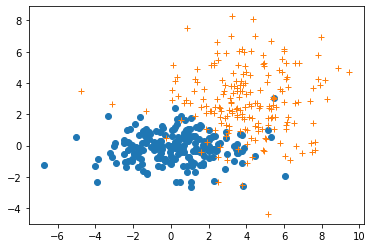

In [156]:
m_1 = [0, 0]
m_2 = [4, 3]
sigma_1 = [2, 1]
sigma_2 = [2, 2]
N = 200
P_1 = 0.5
P_2 = 0.5
X_1 = np.concatenate([np.random.normal(m_1[0], sigma_1[0], N).reshape((-1, 1)), np.random.normal(m_1[1], sigma_1[1], N).reshape((-1, 1))], axis = 1)
X_2 = np.concatenate([np.random.normal(m_2[0], sigma_2[0], N).reshape((-1, 1)), np.random.normal(m_2[1], sigma_2[1], N).reshape((-1, 1))], axis = 1)

plt.figure()
plt.plot(X_1[:, 0], X_1[:, 1], 'o')
plt.plot(X_2[:, 0], X_2[:, 1], '+')
plt.show()

In [157]:
''' Разбиваем данные на обучающую и тестовую выборки '''
X = np.concatenate([X_1, X_2], axis = 0)
Y = np.zeros((X.shape[0], 2)) # Первый класс имеет метку (1, 0); второй класс (0, 1)
Y[:X_1.shape[0], 0] = 1
Y[X_1.shape[0]:, 1] = 1
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state = 0)

In [5]:
Xtrain_1 = Xtrain[np.nonzero(Ytrain[:, 0] == 1)]
Xtrain_2 = Xtrain[np.nonzero(Ytrain[:, 1] == 1)]
print(Xtrain_1.shape)
print(Xtrain_2.shape)

(145, 2)
(155, 2)


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [7]:
''' Выбор параметра происходит эмпирически '''
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'), {'bandwidth': bandwidths}, cv = LeaveOneOut().get_n_splits(Xtrain_1))
grid.fit(Xtrain_1)
h_1 = grid.best_params_['bandwidth']
h_1

0.5857020818056667

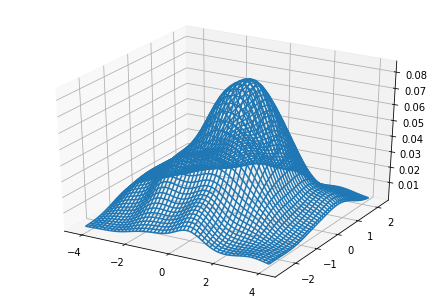

In [8]:
kde_1 = KernelDensity(bandwidth = h_1, kernel = 'gaussian')
kde_1.fit(Xtrain_1) # Выборка имеет вид np.array((N, n)), N - объем выборки, n - размерность пространства признаков
_ = plotHist(Xtrain_1, kde_1, 100, 100)

In [9]:
''' Выбор параметра происходит эмпирически '''
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'), {'bandwidth': bandwidths}, cv = LeaveOneOut().get_n_splits(Xtrain_2))
grid.fit(Xtrain_2)
h_2 = grid.best_params_['bandwidth']
h_2

1.0722672220103238

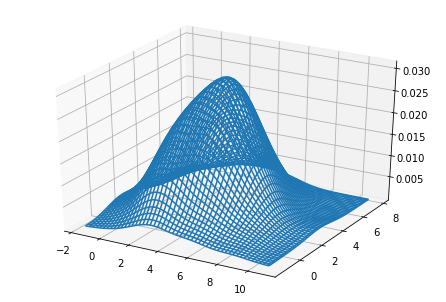

In [10]:
kde_2 = KernelDensity(bandwidth = h_2, kernel = 'gaussian')
kde_2.fit(Xtrain_2) # Выборка имеет вид np.array((N, n)), N - объем выборки, n - размерность пространства признаков
_= plotHist(Xtrain_2, kde_2, 100, 100)

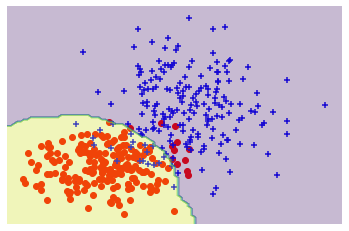

In [11]:
plt.figure()
ax = plt.gca()
r = 1
g = 0
b = 0
ax.scatter(X_1[:, 0], X_1[:, 1], marker = 'o', c = [[r, g, b]])
r = 0
g = 0
b = 1
ax.scatter(X_2[:, 0], X_2[:, 1], marker = '+', c = [[r, g, b]])
ax.axis('off')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num = 100), np.linspace(*ylim, num = 100))
T = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis = 1)
p_1 = np.exp(kde_1.score_samples(T)).reshape(xx.shape)
p_2 = np.exp(kde_2.score_samples(T)).reshape(xx.shape)
d = (np.sign(p_1 * P_1 - p_2 * P_2) + 1)
ax.contourf(xx, yy, 0.5 * d, alpha = 0.3)
plt.show()

In [12]:
''' Точность на обучающем наборе '''
p_1 = np.exp(kde_1.score_samples(Xtrain))
p_2 = np.exp(kde_2.score_samples(Xtrain))
d = np.sign(p_1 * P_1 - p_2 * P_2)
Y = np.zeros((d.shape[0], 2))
Y[np.nonzero(d == -1)[0], 1] = 1
Y[np.nonzero(d == 1)[0], 0] = 1
K = len(np.nonzero(np.linalg.norm(Y - Ytrain, axis = 1) == 0)[0])
print((K / len(Y[:, 0])) * 100, ' %')

90.66666666666666  %


In [13]:
''' Точность на тестовом наборе '''
p_1 = np.exp(kde_1.score_samples(Xtest))
p_2 = np.exp(kde_2.score_samples(Xtest))
d = np.sign(p_1 * P_1 - p_2 * P_2)
Y = np.zeros((d.shape[0], 2))
Y[np.nonzero(d == -1)[0], 1] = 1
Y[np.nonzero(d == 1)[0], 0] = 1
K = len(np.nonzero(np.linalg.norm(Y - Ytest, axis = 1) == 0)[0])
print((K / len(Y[:, 0])) * 100, ' %')

94.0  %


#### $\S 3$. Распознавание рукописных цифр

**Задание.** Дана выборка, содержащая изображения рукописных цифр 0,1,2,3,4. Изображения размером 8x8 пикселей. Выбрать в качестве вектор-признаков яркости пикселей изображения, т.е., если I - изображение, то вектор-признак такого изображения будет равен $x = I.flatten()\in\mathbf{R}^{64}$. Построить с помощью байесовского классификатора решающую функцию для разделения двух классов $\Omega_1$, $\Omega_2$, один из которых содержит цифру 4, а другой все остальные цифры. Оценить точность на тестовой выборке. Для оценки плотностей распределения использовать ядерный метод.

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split # Для разбиения данных
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
digits = load_digits(n_class = 5) # загружаем изображения от 0 до 4
X = digits.images.reshape((digits.images.shape[0], 64)) # вектор-признаки
Y = digits.target                                       # метки

In [3]:
Yh = pd.get_dummies(Y).values

In [30]:
Yh

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]], dtype=uint8)

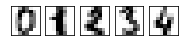

In [4]:
fig, ax = plt.subplots(1, 5, figsize = (3, 3))
for i, axi in enumerate(ax.flat):
    #axi.imshow(digits.images[i], cmap = 'binary')
    axi.imshow(X[i, :].reshape((8, 8)), cmap = 'binary')
    axi.set(xticks = [], yticks = [])

In [5]:
Xtrain, Xtest, Ytrain_orig, Ytest_orig = train_test_split(X, Y, random_state = 0)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Yh, random_state = 0)

In [6]:
Xtrain.shape

(675, 64)

In [7]:
Ptrain = Ytrain.sum(axis=0)/ Ytrain.sum()
Ptrain

array([0.19851852, 0.20148148, 0.19259259, 0.20148148, 0.20592593])

In [8]:
Ptest = Ytest.sum(axis=0)/ Ytest.sum()
Ptest

array([0.19469027, 0.20353982, 0.2079646 , 0.2079646 , 0.18584071])

In [9]:
Xtrain_c = []
for i in range(5):
    Xtrain_c.append(Xtrain[np.nonzero(Ytrain[:, i] == 1)])
    print(i, Xtrain[i].shape)

0 (64,)
1 (64,)
2 (64,)
3 (64,)
4 (64,)


In [10]:
Xtrain_c[0]

array([[ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  9., ...,  1.,  0.,  0.],
       [ 0.,  0.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  4., ..., 11.,  0.,  0.],
       [ 0.,  0.,  1., ...,  4.,  0.,  0.],
       [ 0.,  0.,  4., ..., 10.,  0.,  0.]])

In [11]:
Xtrain_c[1]

array([[ 0.,  0.,  0., ..., 14.,  1.,  0.],
       [ 0.,  0.,  7., ..., 16., 16.,  5.],
       [ 0.,  0.,  7., ..., 16., 16., 15.],
       ...,
       [ 0.,  0.,  4., ..., 11.,  0.,  0.],
       [ 0.,  0.,  3., ..., 16., 16., 16.],
       [ 0.,  0.,  0., ...,  5.,  0.,  0.]])

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [13]:
h = []
bandwidths = 10 ** np.linspace(-1, 1, 100)
for i in tqdm(range(5)):
    grid = GridSearchCV(KernelDensity(kernel = 'gaussian'), {'bandwidth': bandwidths}, 
                        cv = LeaveOneOut().get_n_splits(Xtrain_c[i]))
    grid.fit(Xtrain_c[i])
    h.append(grid.best_params_['bandwidth'])

In [14]:
h

[1.291549665014884,
 1.3530477745798075,
 1.7886495290574351,
 1.6297508346206444,
 1.3530477745798075]

In [15]:
kde = []
for i in range(len(h)):
    kde.append(KernelDensity(bandwidth = h[i], kernel = 'gaussian'))
    kde[i].fit(Xtrain_c[i]) # Выборка имеет вид np.array((N, n)), N - объем выборки, n - размерность пространства признаков
#     _ = plotHist(Xtrain_c[i], kde[i], 100, 100)

In [16]:
''' Точность на обучающем наборе '''
p = []
for i in tqdm(range(5)):
    p.append(np.exp(kde[i].score_samples(Xtrain)))

p = np.array(p).T

In [17]:
p

array([[1.03072483e-120, 8.33038168e-037, 1.01230690e-125,
        1.13593383e-178, 5.54732206e-108],
       [0.00000000e+000, 8.33038168e-037, 1.34137519e-122,
        3.61266073e-170, 5.05412833e-302],
       [0.00000000e+000, 8.33038168e-037, 2.87317701e-130,
        1.33154869e-181, 0.00000000e+000],
       ...,
       [4.75182074e-156, 3.70562298e-239, 1.59844743e-189,
        2.31150828e-232, 8.15058927e-037],
       [1.26961983e-088, 4.26041862e-061, 3.83436175e-198,
        1.82682901e-163, 8.15058927e-037],
       [1.65969507e-035, 1.95494820e-065, 6.95442798e-165,
        1.40280455e-144, 1.05934284e-268]])

In [18]:
(p * Ptrain).shape

(675, 5)

In [19]:
Y_pred = np.argmax(p * Ptrain, axis=1)

In [20]:
Y_pred.shape

(675,)

In [21]:
Y_pred[:20]

array([1, 1, 1, 0, 2, 4, 0, 0, 2, 1, 4, 1, 2, 4, 0, 2, 1, 0, 0, 3])

In [22]:
Ytrain_orig[:20]

array([1, 1, 1, 0, 2, 4, 0, 0, 2, 1, 4, 1, 2, 4, 0, 2, 1, 0, 0, 3])

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('Acc = {}, F1 = {}'.format(accuracy_score(Ytrain_orig, Y_pred), 
      f1_score(Ytrain_orig, Y_pred, average='macro')))

Acc = 1.0, F1 = 1.0


In [24]:
''' Точность на обучающем наборе '''
pt = []
for i in tqdm(range(5)):
    pt.append(np.exp(kde[i].score_samples(Xtest)))

pt = np.array(pt).T

In [25]:
(pt * Ptest).shape

(226, 5)

In [26]:
Y_pred_t = np.argmax(pt * Ptest, axis=1)

In [27]:
Y_pred_t.shape

(226,)

In [28]:
Y_pred_t[:20]

array([1, 2, 0, 4, 2, 4, 0, 1, 3, 3, 3, 3, 2, 4, 4, 1, 1, 1, 2, 4])

In [29]:
print('Acc = {}, F1 = {}'.format(accuracy_score(Ytest_orig, Y_pred_t), 
      f1_score(Ytest_orig, Y_pred_t, average='macro')))

Acc = 0.7522123893805309, F1 = 0.757851999297465


### Литература

1. Bowman, A. (1984). An alternative method of cross-validation for the smoothing of density estimates. Biometrika 71 353–360.